# Classification for bank churn

In this notebook we will use BlueCast's EDA capabilities to analyse a Kaggle churn dataset. 
The dataset can be downloaded [here](https://www.kaggle.com/competitions/playground-series-s4e1/data).

# Import libraries

In this notebook we import the package locally. However this is equivalent to !pip install bluecast==1.6.0

In [1]:
import sys

sys.path.append("/home/thomas/IdeaProjects/BlueCast")

In [2]:
from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.blueprints.cast_regression import BlueCastRegression
from bluecast.blueprints.cast_cv_regression import BlueCastCVRegression
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig, XgboostTuneParamsRegressionConfig
from bluecast.experimentation.tracking import ExperimentTracker
from bluecast.general_utils.general_utils import save_to_production, load_for_production
from bluecast.preprocessing.feature_creation import AddRowLevelAggFeatures
from bluecast.preprocessing.feature_types import FeatureTypeDetector
from bluecast.evaluation.eval_metrics import ClassificationEvalWrapper
from bluecast.eda.data_leakage_checks import (
    detect_categorical_leakage,
    detect_leakage_via_correlation,
)
from bluecast.monitoring.data_monitoring import DataDrift

import numpy as np
import pandas as pd

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Import the data

In [3]:
train = pd.read_csv("playground-series-s4e1/train.csv")
test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

# Define constants

In [4]:
TARGET = "Exited"

# First look at the data

In this section we use the usual Pandas methods to get a first impression.

In [5]:
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [7]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [8]:
train["Exited"].value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

We see that:

* we have categorical columns to deal with
* there aren't any NULLs
* the dataset is not imbalanced
* we have plenty of training data

# EDA using BlueCast

After our first inspection we dive deeper and use BlueCast's EDA capabilities to draw further conclusions.

In [9]:
from bluecast.eda.analyse import (
    plot_andrews_curve,
    bi_variate_plots,
    univariate_plots,
    plot_classification_target_distribution_within_categories,
    plot_count_pairs,
    plot_distribution_by_time,
    correlation_heatmap,
    correlation_to_target,
    plot_ecdf,
    plot_pca,
    plot_pca_biplot,
    plot_pca_cumulative_variance,
    plot_theil_u_heatmap,
    plot_tsne,
    check_unique_values,
    plot_null_percentage,
    mutual_info_to_target,
    plot_pie_chart,
)

from bluecast.preprocessing.feature_types import FeatureTypeDetector

## Feature type detection

Sometimes Pandas detects objects where numerical features are present. For this purpose BlueCast has a feature type detector. During the training pipelines this is called automatically, but here we call it manually to see what BlueCast detects.

In [10]:
# Here we automatically detect the numeric columns
feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train)

INFO:root:Start detecting and casting feature types.
INFO:root:Dropped the following columns as being Nulls only: [].
INFO:root:Dropped the following columns as being Nulls only: [].
INFO:root:Dropped the following columns as constants only: [].
INFO:root:Dropped the following columns as constants only: [].


In [11]:
feat_type_detector.num_columns

['id',
 'CustomerId',
 'CreditScore',
 'Tenure',
 'NumOfProducts',
 'Exited',
 'Age',
 'Balance',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [12]:
feat_type_detector.cat_columns

['Surname', 'Geography', 'Gender']

In [13]:
# detect columns with a very high share of unique values
many_unique_cols = check_unique_values(train_data, train_data.columns.to_list(), threshold=0.9)
many_unique_cols

['id']

We can see that the ´id´ column has more than 90% unique values (in this case even 100%). We should probably drop the ´id´ column.

## Visualizing the data

In the next part we plot our data using the wide toolkit of BlueCast.

### Target distribution

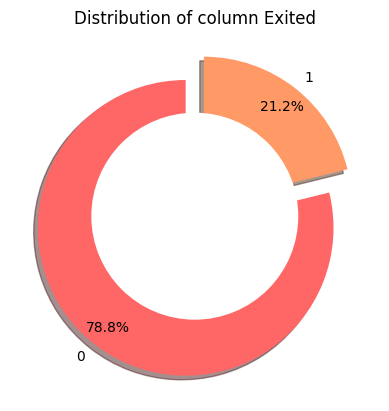

In [14]:
plot_pie_chart(
        train_data,
        TARGET
)

### Univariate plots

First of all we will look at all features individually.

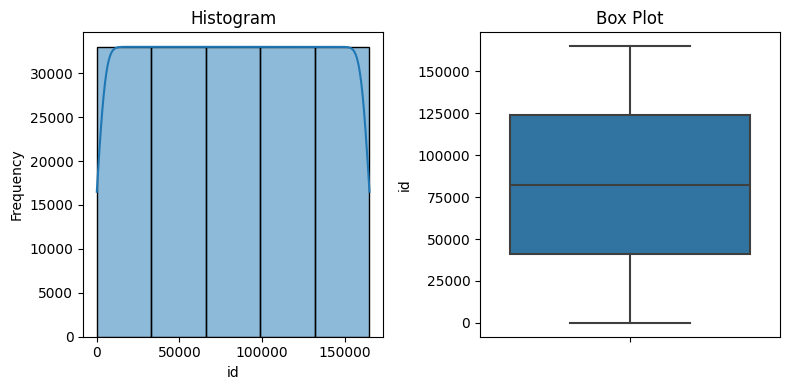

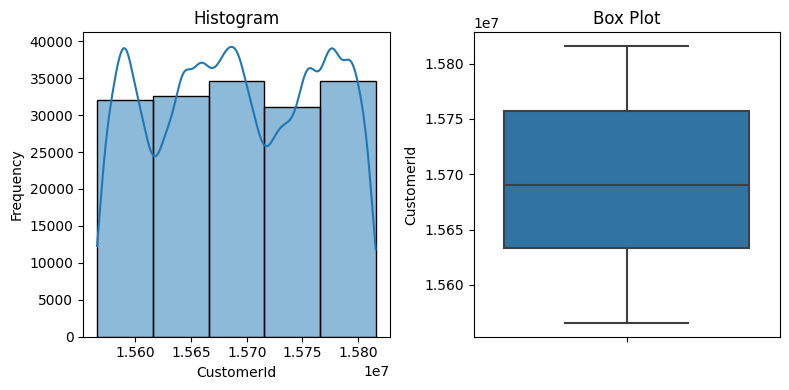

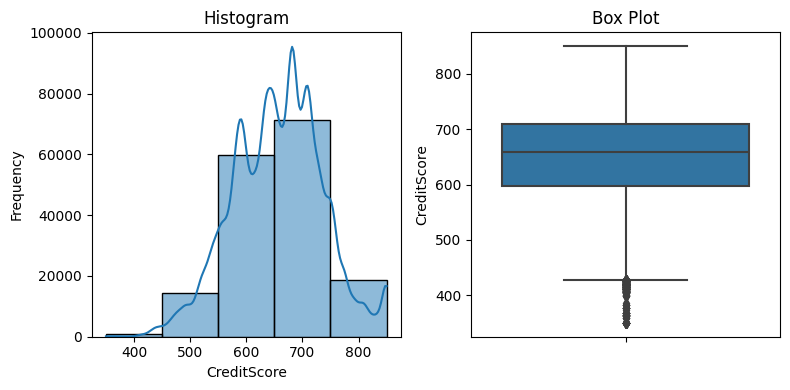

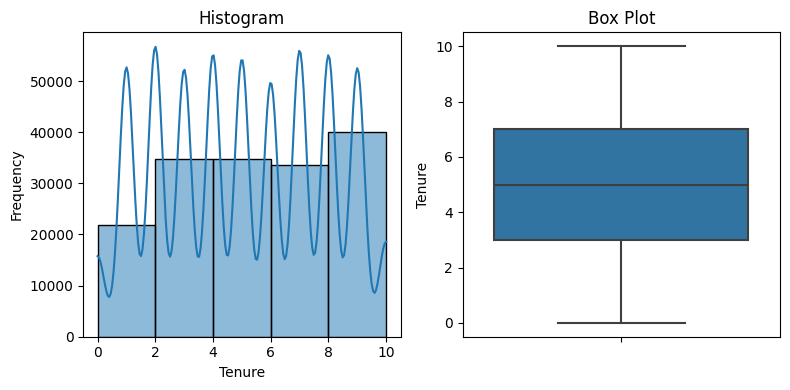

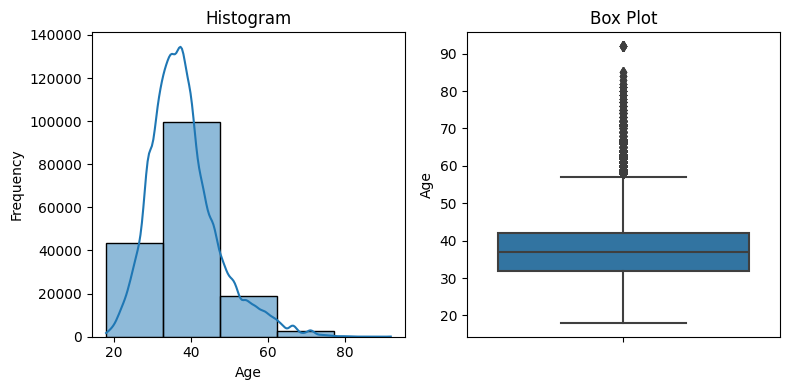

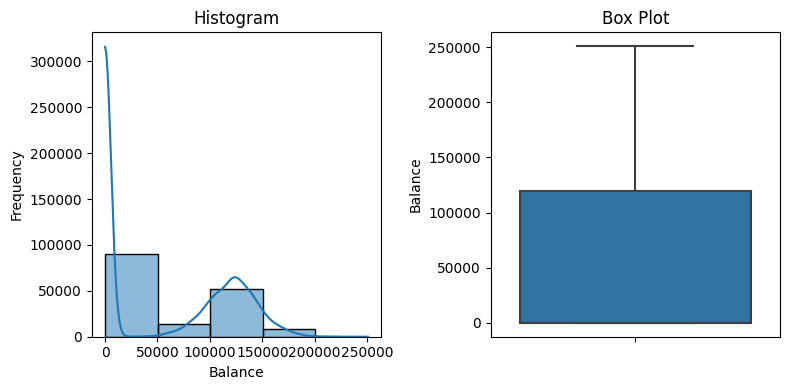

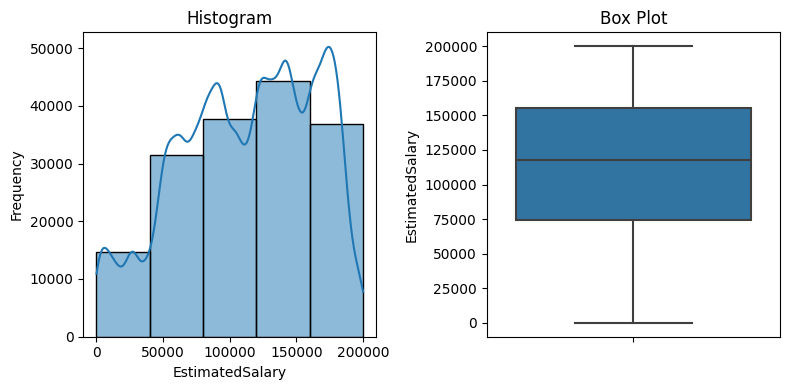

In [15]:
univariate_plots(
        train_data.loc[:, feat_type_detector.num_columns], 
)

Balance seems to be zero-inflated. This might be interesting during the modelling phase.

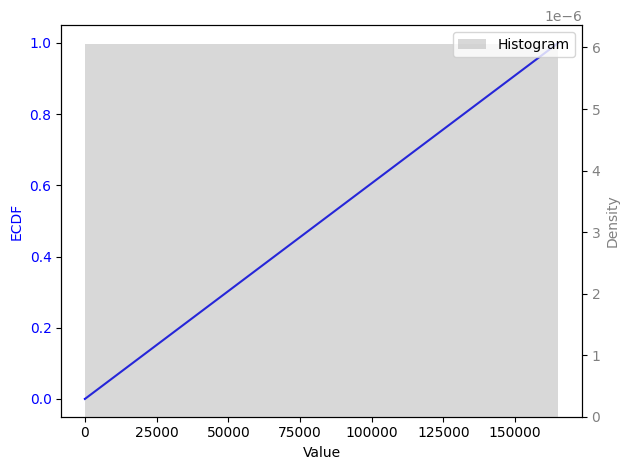

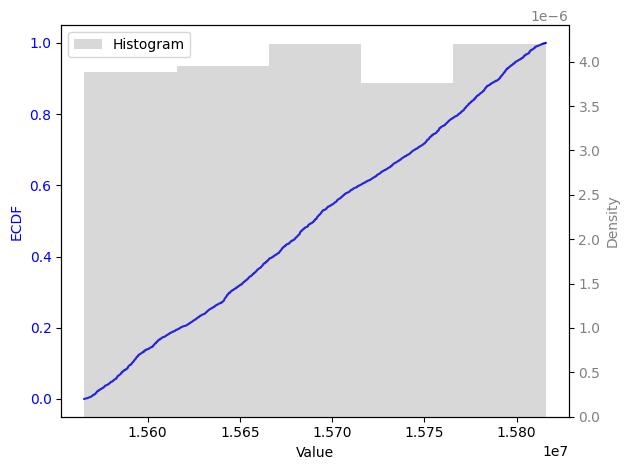

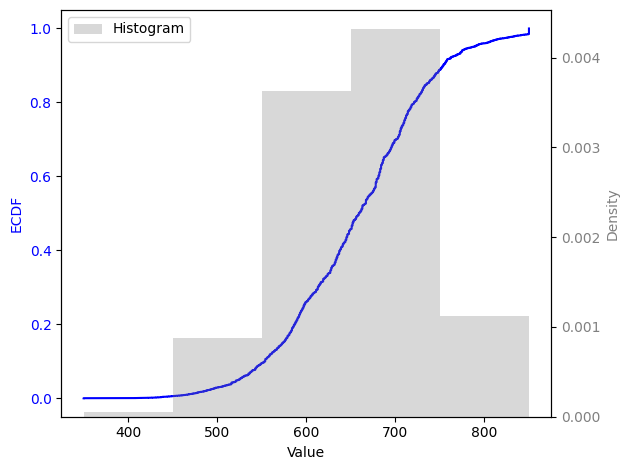

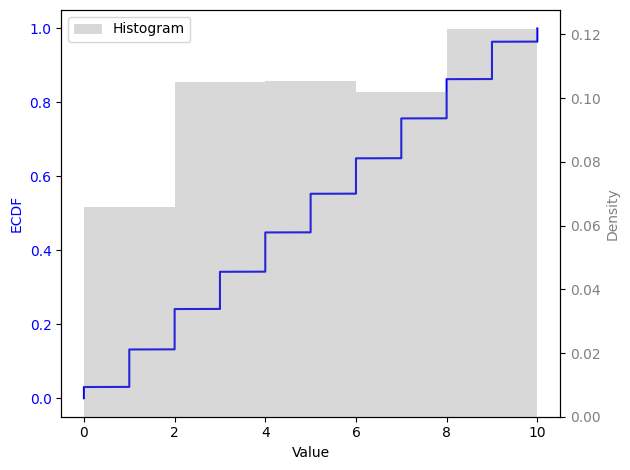

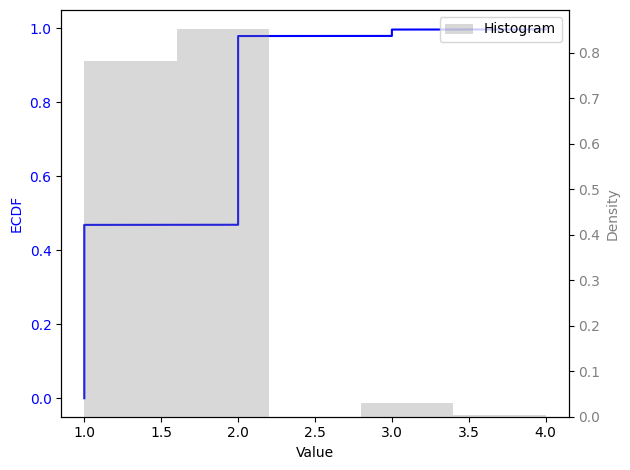

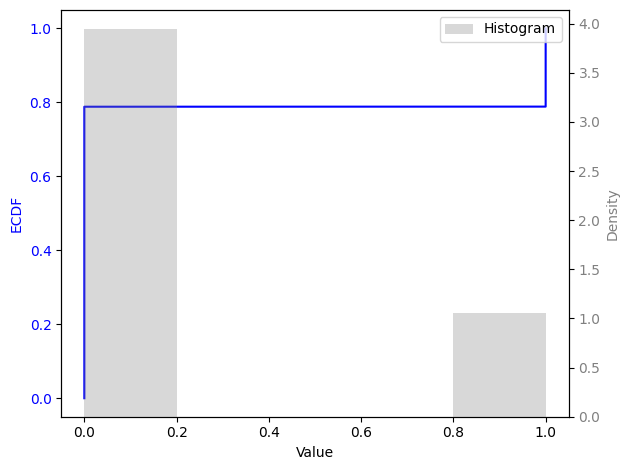

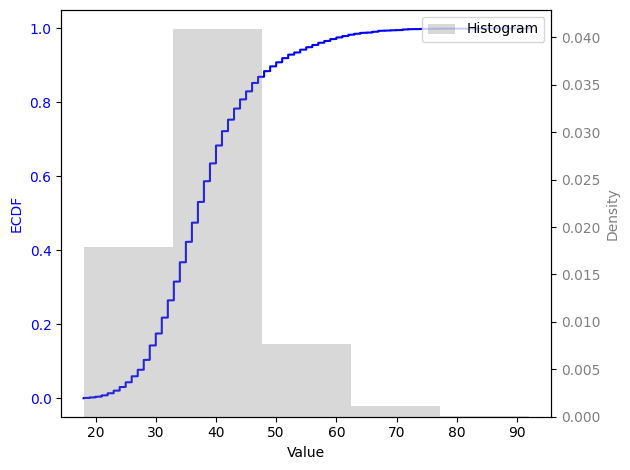

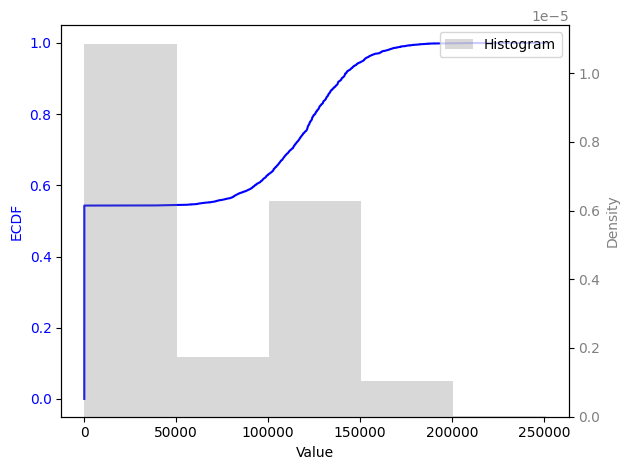

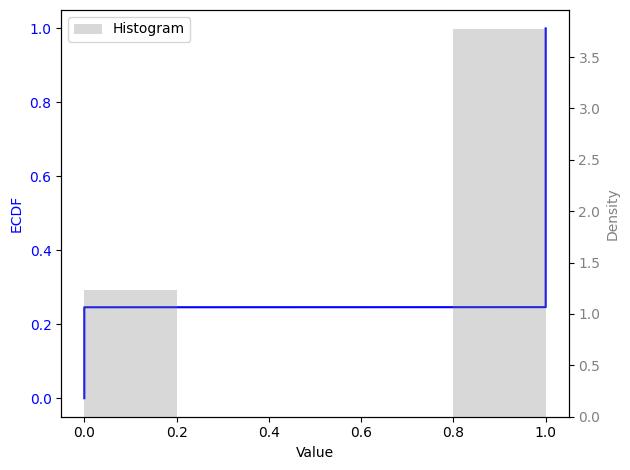

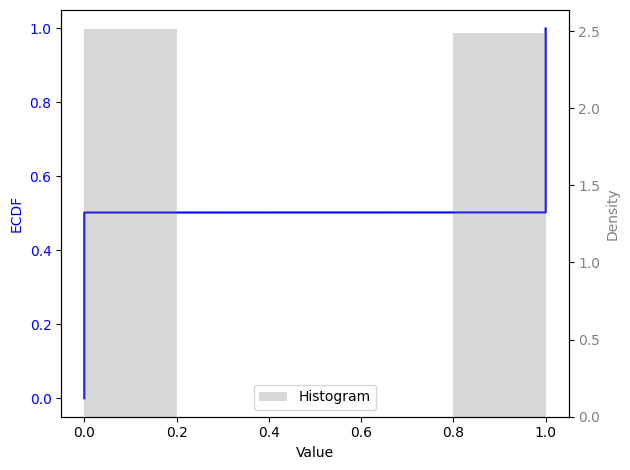

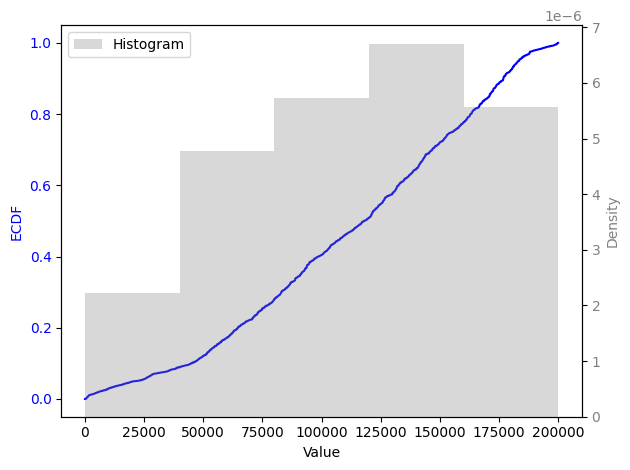

In [16]:
plot_ecdf(
        train_data, feat_type_detector.num_columns,  plot_all_at_once=False
)

From the empirical cumulative distribution functions we get some interesting insights:

* even though ´FeatureTypeDetector´ marked all columns as numerical, some of them are clearly boolean
* ´CustomerId´ has duplications
* Tenure is a discrete numeric festure and not continous, same for NumOfProducts

## Relationship to target

After learning from our features in isolation we can try to understand their relationship to the target variable.

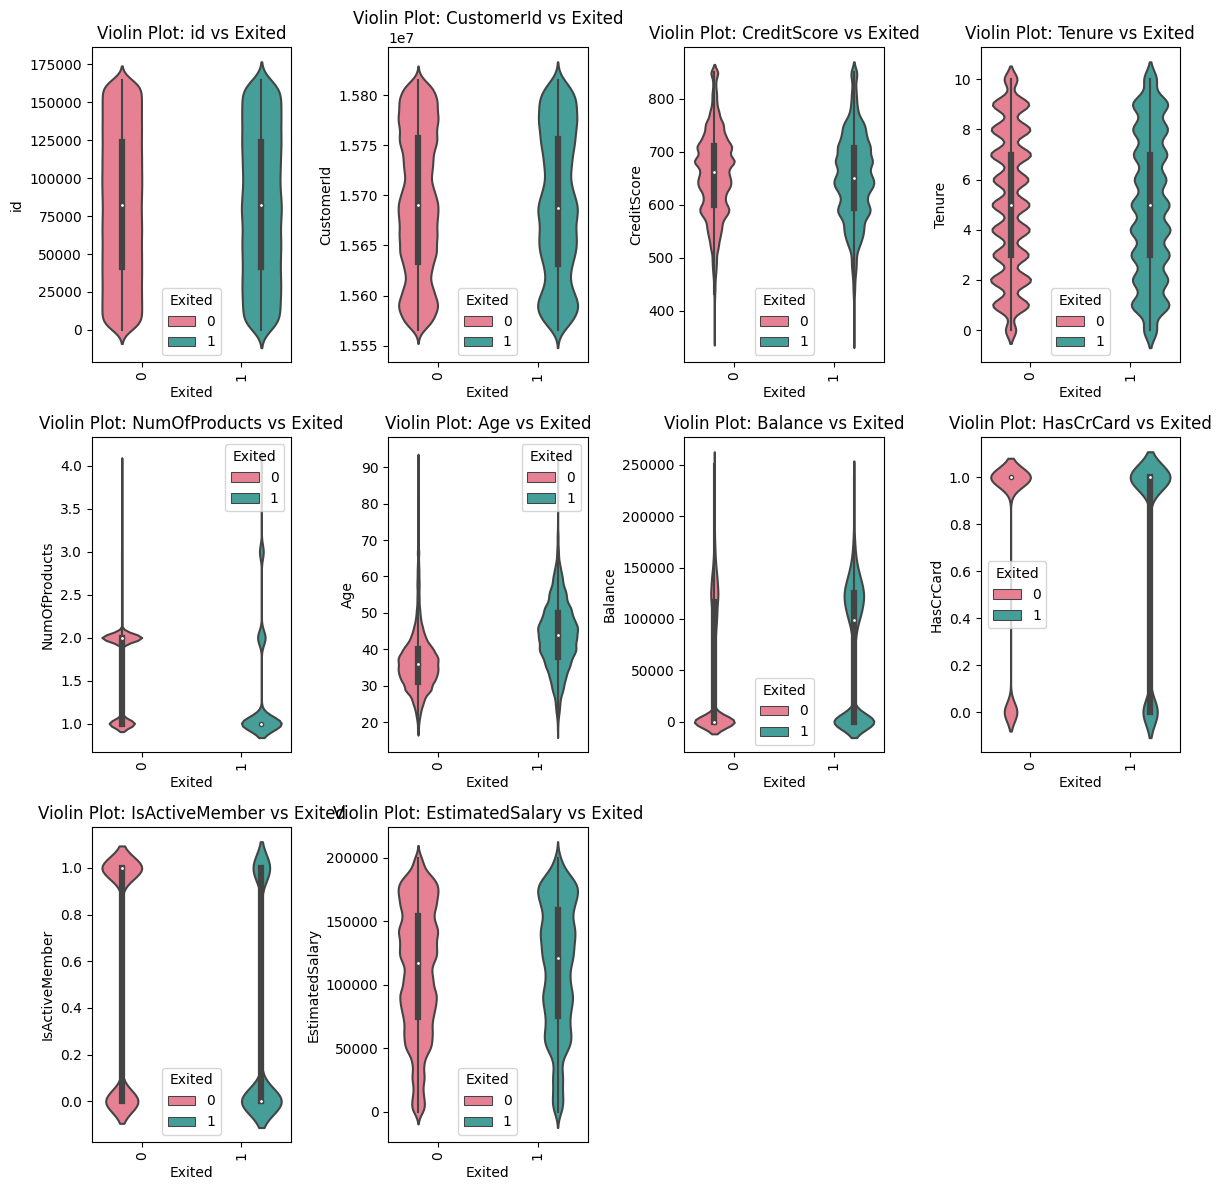

In [17]:
bi_variate_plots(
    train_data.loc[:, feat_type_detector.num_columns],
      TARGET
)

In the bivariate plots we found some interesting patterns:

* The age of churned customers seems to be higher than the age of non-churned customers.
* Customers with higher balance seem to have more churn.
* Customers with more products seem to churn less

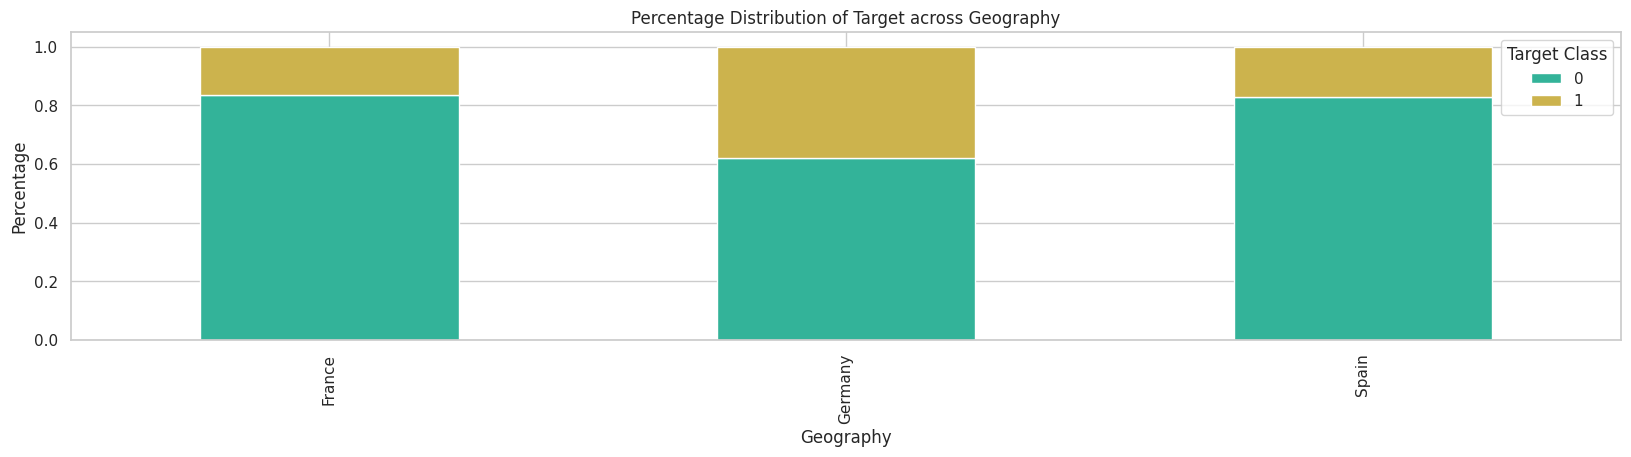

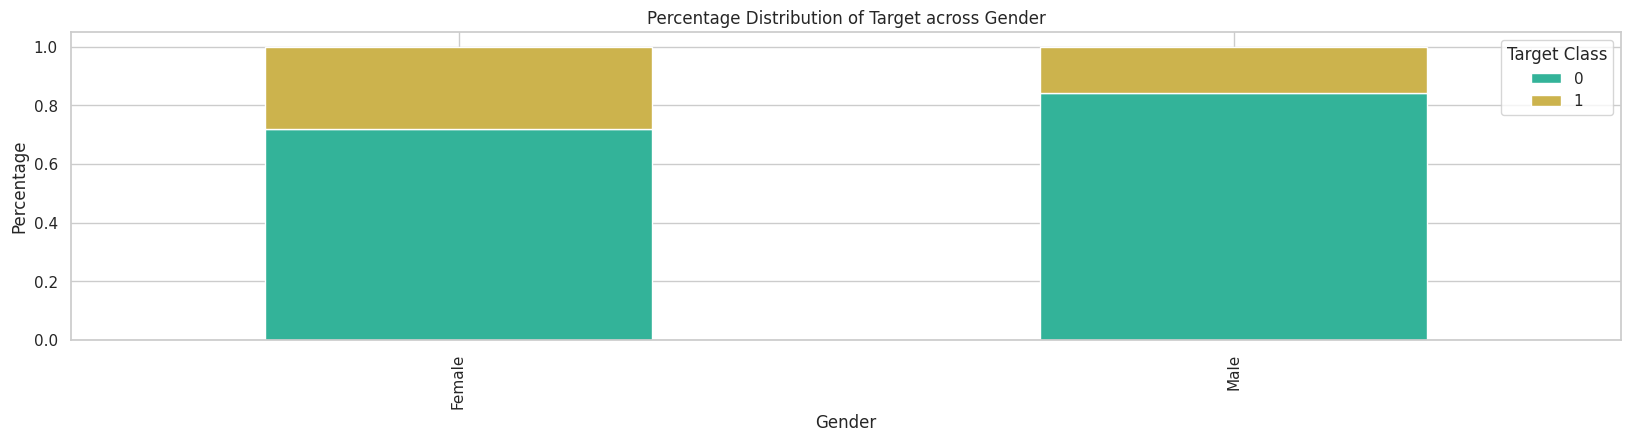

In [18]:
plot_classification_target_distribution_within_categories(
    train,
    cat_columns=train_data.loc[:, feat_type_detector.cat_columns].drop("Surname", axis=1),
    target_col=TARGET
)

We can see that the target class has a higher share when the country is Germany. Also among females we see more churn.

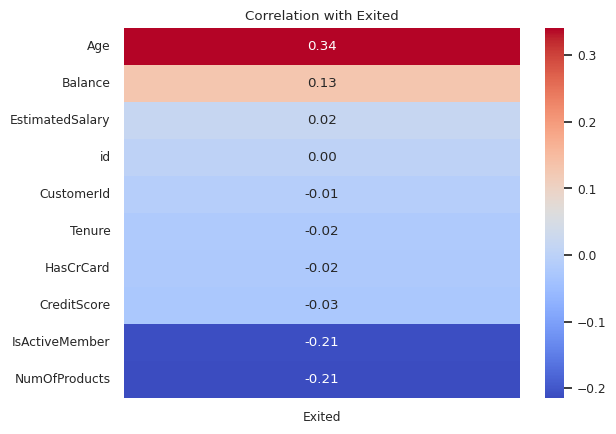

In [19]:
correlation_to_target(train_data.loc[:, feat_type_detector.num_columns], TARGET)

What we saw above is also evident as a correlation. The higher the age the more likely seems to be the churn. Also the balance shows this pattern, but much weaker.

For number of products we see the opposite. The same for active membersip, which shouldn't be a surprise.

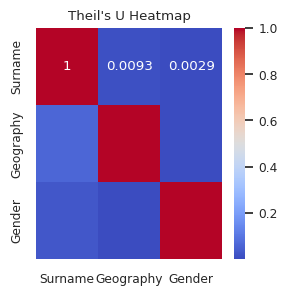

In [20]:
theil_matrix = plot_theil_u_heatmap(train_data, feat_type_detector.cat_columns)

Theil's U tells us that the categorical features have very litthle explainability for the target column. 

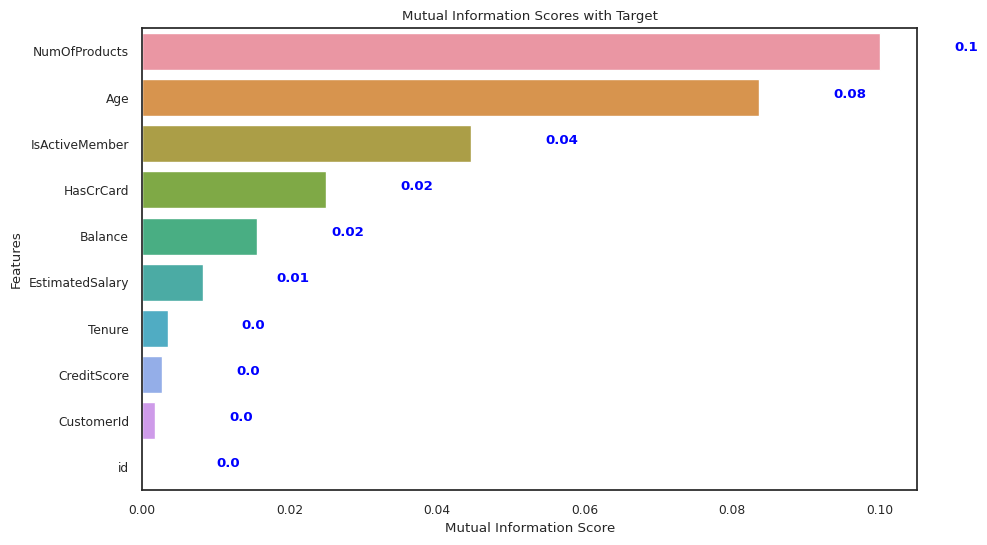

In [21]:
extra_params = {"random_state": 30}
mutual_info_to_target(train_data.loc[:, feat_type_detector.num_columns], TARGET, class_problem="binary", **extra_params)

While the correlations above measured linear signal, we can extent this to also understand non-linear feature explainability. The mutual information score shows similar patterns to what we have seen before. It is worth noting that ´id´ seems to have no value at all.

### PCA

In the next step we make use of PCA. 

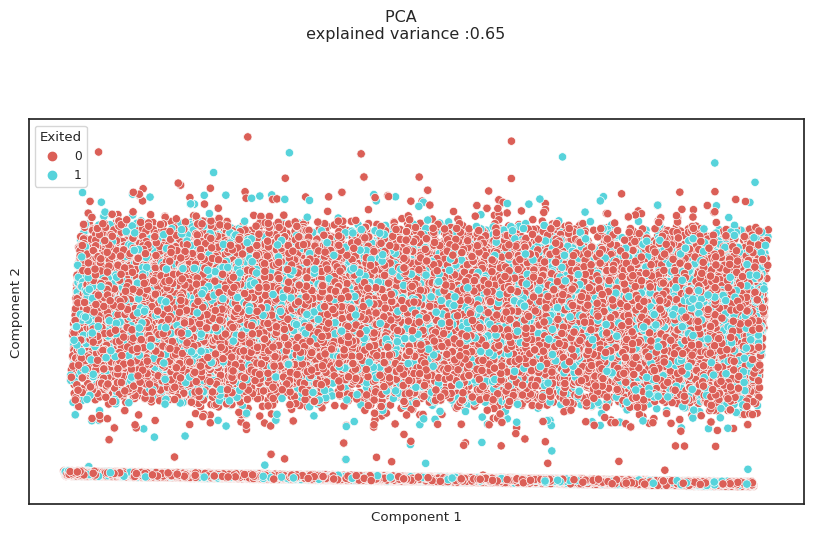

In [22]:
plot_pca(
    train_data.loc[:, feat_type_detector.num_columns],
    TARGET
)

It does not look like linear models will have an easy time separating those classes. However two components can only capture 65% of the original variance. Let's see how many components we would require to capture most of the variance.

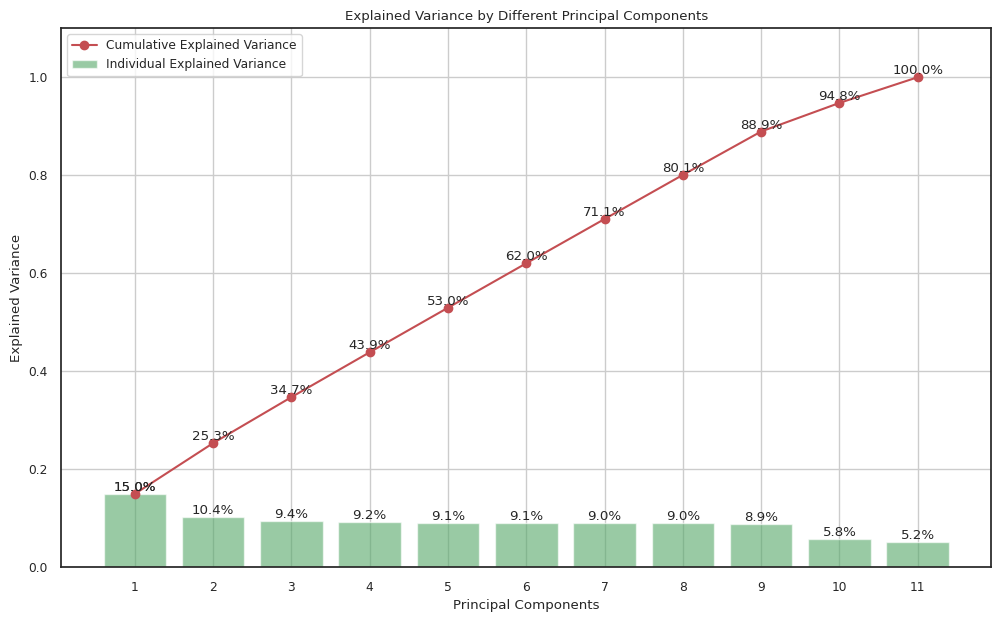

In [23]:
plot_pca_cumulative_variance(
    train_data.loc[:, feat_type_detector.num_columns],
    TARGET,
    11 # equals number of features, optional
)

Basically we need all features to capture all variance.

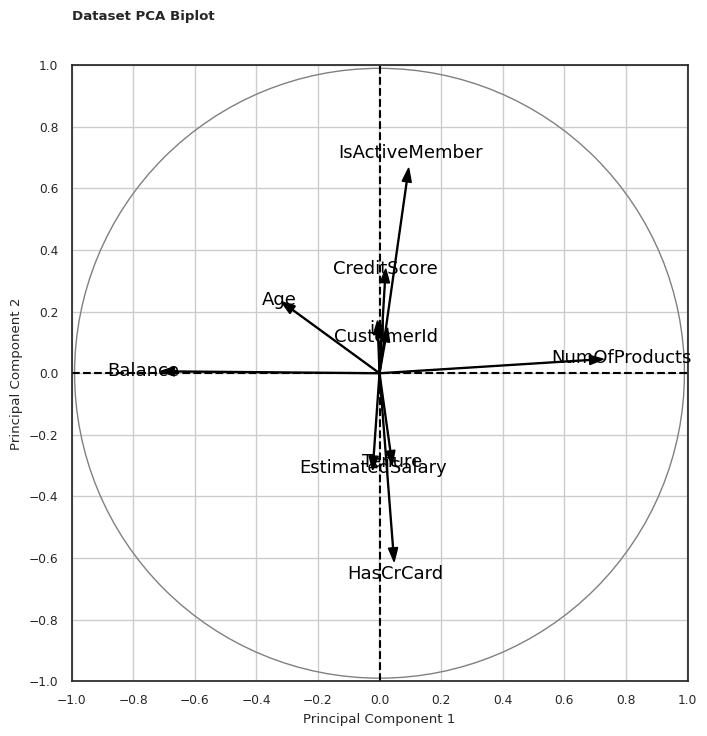

In [24]:
plot_pca_biplot(
  train_data.loc[:, feat_type_detector.num_columns],
  TARGET
)

Here we can see how much which feature contributed to which component. Number of products had most influence on component 1 while active membership heavily impacts component 2.

### Relationships between features

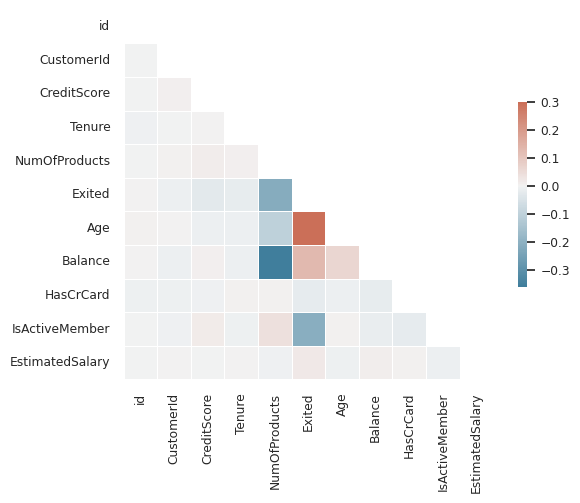

In [25]:
correlation_heatmap(train_data.loc[:, feat_type_detector.num_columns])

From the correlations between features we can see that number of products and balance are negatively correlated. This feels quite counterintuitive at first. Maybe the company attracts only smaller customers with some of their products.

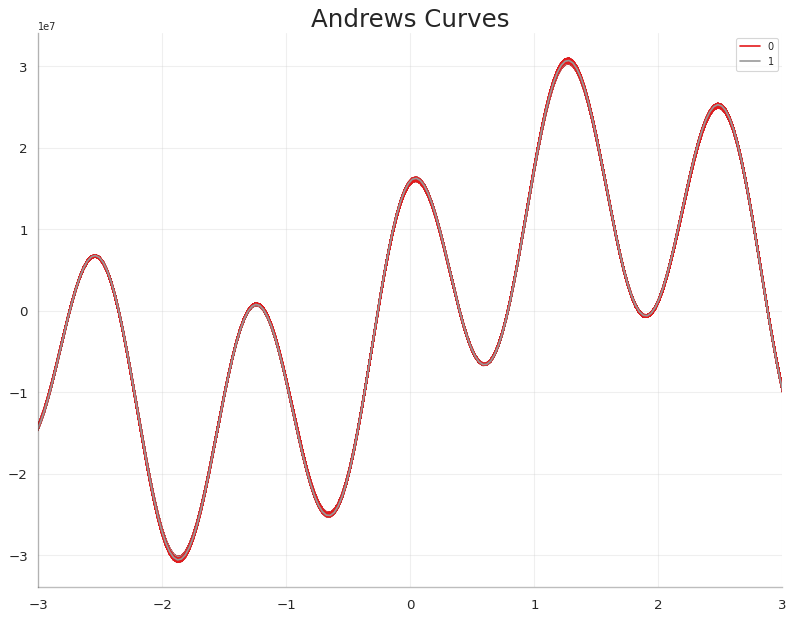

In [26]:
plot_andrews_curve(
  train_data.loc[:, feat_type_detector.num_columns],
  TARGET,
  n_samples=1000,
  random_state=20
)

Andrews curve brings the data into a lower space by retaining
the relative distance between other samples and keeping the
variance similar. We can show how similar samples are with
regards to the same output. 

Here it looks lime the samples cannot be diffentiated. This might be a hard to solve modelling problem.

### Leakage detection

Even thoug we haven't seen any indicator above, we run some leakage detection additionally.

In [27]:
# Detect leakage of numeric columns based on correlation
result = detect_leakage_via_correlation(
        train_data.loc[:, feat_type_detector.num_columns], TARGET, threshold=0.9
)

No leakage has been detected


In [28]:
# Detect leakage of categorical columns based on Theil's U
result = detect_categorical_leakage(
        train_data.loc[:, feat_type_detector.cat_columns + [TARGET]], TARGET, threshold=0.9
)

No leakage has been detected


## Relationship between datasets

Technically this is not part of the EDA step unless we have split our training data and want to check for data or concept drift over time for example.

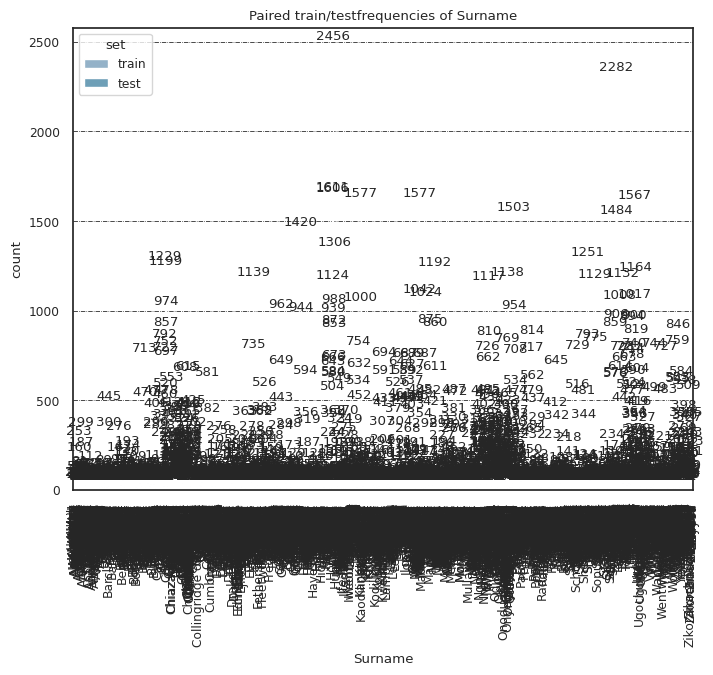

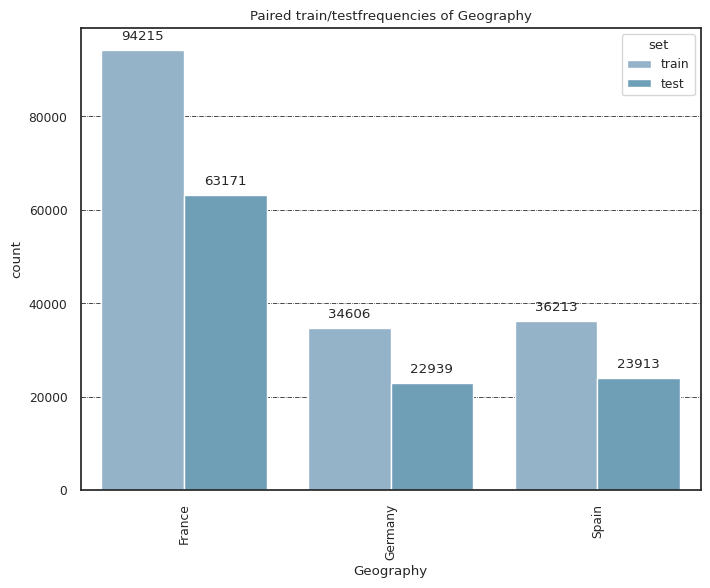

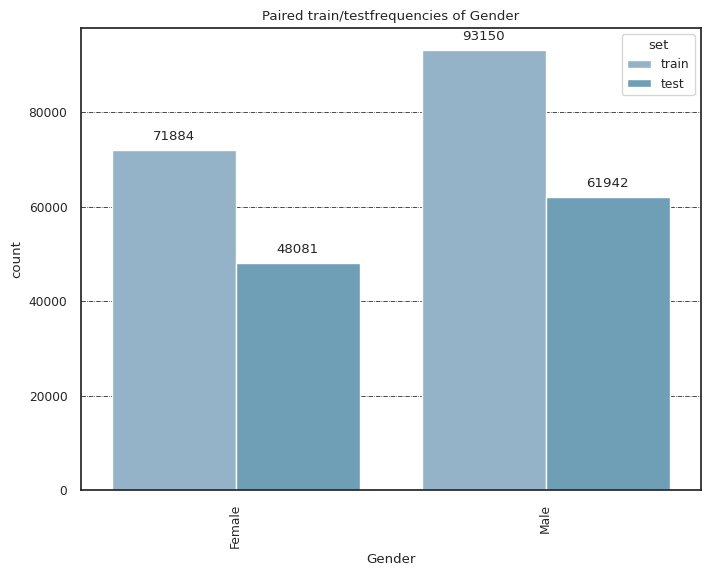

In [29]:
plot_count_pairs(
    train,
    test,
    cat_cols=train_data.loc[:, feat_type_detector.cat_columns],
)

We can see that surnames are rather unique and will not give us any generalizable pattern. Removing surnames will also be better from an ethical perspective and prevent adding biases here.

In [30]:
data_drift_checker = DataDrift()
# statistical data drift checks for numerical features
data_drift_checker.adversarial_validation(train.drop(TARGET, axis=1), test, cat_columns=feat_type_detector.cat_columns)

array([0.99999242])

Our two datasets are easy to differentiate. This might be due to the columns we want to drop. We do the check again, but this time without these overfitting-prone columns.

In [31]:
train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [32]:
to_drop = ["id", "CustomerId", "Surname"]
cat_columns = [col for col in feat_type_detector.cat_columns if col not in to_drop]

data_drift_checker = DataDrift()
# statistical data drift checks for numerical features
data_drift_checker.adversarial_validation(
    train.drop(to_drop + [TARGET], axis=1), 
    test.drop(to_drop, axis=1), 
    cat_columns=cat_columns
)

array([0.50129744])

Without the drifting columns the datadrift seems to be gone entirely. This might matter especíally for tree-based models.

# Summary

We made it all the way through the EDA part, congratulations. Let us summarize what we learned and which actions we can take based on these learnings.

* ´id´ column provides no value and should be dropped for the model training (at least we should test it)
* ´customerid´ has some duplications. We should test dropping the column and potentially deduplicate the dataset before to prevent leakage
* 'surname' has lots of unique values and should be dropped as well. It will lead to overfitting and potentially adds unethical biases (in real world applications)
* We need all other columns though. Feature selection will just lose information (at least when dropping original features)
* Most features are far awar from having a normal distribution. If we consider a linear model, we need feature transformations.
* Target encoding might be a good fit here as the categories show different levels of target explainability
* We could consider constructing new features from the ones with highest churn probabiity i.e. into churn risk groups